### Урок3. Связь бизнес-показателей и DS-метрик

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

Повторяю операцию составления Pipeline из урока (без изменений)

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

FeatureUnion

In [6]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

#### Классификатор Логистическая регрессия и  кросс-валидация

In [7]:
classifier_lr = Pipeline([
    ('features',feats),
    ('classifier LR', LogisticRegression(random_state = 42)),
])

#запустим кросс-валидацию
cv_scores_lr = cross_val_score(classifier_lr, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_lr = np.mean(cv_scores_lr)
cv_score_std_lr = np.std(cv_scores_lr)
print('CV score LR is {}+-{}'.format(cv_score_lr, cv_score_std_lr))

#обучим пайплайн на всем тренировочном датасете
classifier_lr.fit(X_train, y_train)
y_score_lr = classifier_lr.predict_proba(X_test)[:, 1]

CV score LR is 0.7867401104915408+-0.00852135511666111


In [8]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

b=1

precision_lr, recall_lr, thresholds = precision_recall_curve(y_test.values, y_score_lr)
fscore_lr = (1+b**2)*(precision_lr * recall_lr) / (b**2*precision_lr + recall_lr)
# locate the index of the largest f score
ix = np.argmax(fscore_lr)
print('Linear Regression Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore_lr[ix],
                                                                        precision_lr[ix],
                                                                        recall_lr[ix]))

precision_lr, recall_lr, fscore_lr = precision_lr[ix], recall_lr[ix], fscore_lr[ix]

Linear Regression Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


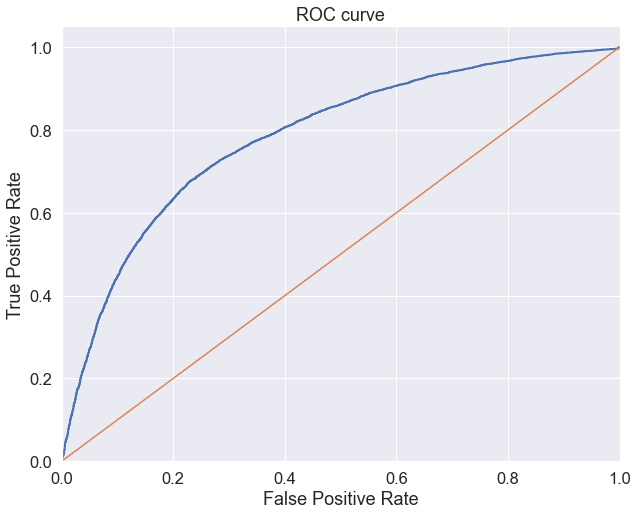

In [9]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score_lr, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [10]:
from sklearn.metrics import roc_auc_score, log_loss

lr_roc_auc_score = roc_auc_score(y_true=y_test, y_score=classifier_lr.predict_proba(X_test)[:,1])
lr_log_loss = log_loss(y_true=y_test, y_pred=classifier_lr.predict_proba(X_test)[:,1])

print("LR roc auc score: {}".format(lr_roc_auc_score))
print("LR log loss score: {}".format(lr_log_loss))

LR roc auc score: 0.7840347790421852
LR log loss score: 0.5779604008230668


In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


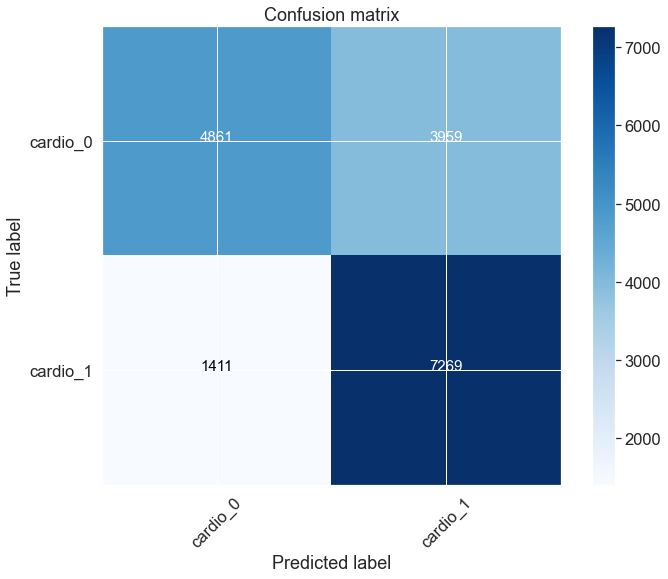

In [12]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score_lr>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [13]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

#### Классификатор Бустинг и  кросс-валидация

In [14]:
classifier_boost = Pipeline([
    ('features',feats),
    ('classifier BOOST', GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,
                                                    max_depth=3, random_state = 42)),
])


#запустим кросс-валидацию
cv_scores_boost = cross_val_score(classifier_boost, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_boost = np.mean(cv_scores_boost)
cv_score_std_boost = np.std(cv_scores_boost)
print('CV score Boost is {}+-{}'.format(cv_score_boost, cv_score_std_boost))

#обучим пайплайн на всем тренировочном датасете
classifier_boost.fit(X_train, y_train)
y_score_boost = classifier_boost.predict_proba(X_test)[:, 1]

CV score Boost is 0.7986690188182273+-0.006708492792320666


In [15]:
b=1

precision_b, recall_b, thresholds = precision_recall_curve(y_test.values, y_score_boost)
fscore_b = (1+b**2)*(precision_b * recall_b) / (b**2*precision_b + recall_b)
# locate the index of the largest f score
ix = np.argmax(fscore_b)
print('Boost Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore_b[ix],
                                                                        precision_b[ix],
                                                                        recall_b[ix]))

precision_b, recall_b, fscore_b = precision_b[ix], recall_b[ix], fscore_b[ix]

Boost Best Threshold=0.346878, F-Score=0.738, Precision=0.663, Recall=0.831


In [16]:
boost_roc_auc_score = roc_auc_score(y_true=y_test, y_score=classifier_boost.predict_proba(X_test)[:,1])
boost_log_loss_score = log_loss(y_true=y_test, y_pred=classifier_boost.predict_proba(X_test)[:,1])

print("Boost roc auc score: {}".format(boost_roc_auc_score))
print("Boost log loss score: {}".format(boost_log_loss_score))

Boost roc auc score: 0.7989168025120956
Boost log loss score: 0.5444663771551529


Confusion matrix, without normalization
[[5148 3672]
 [1465 7215]]


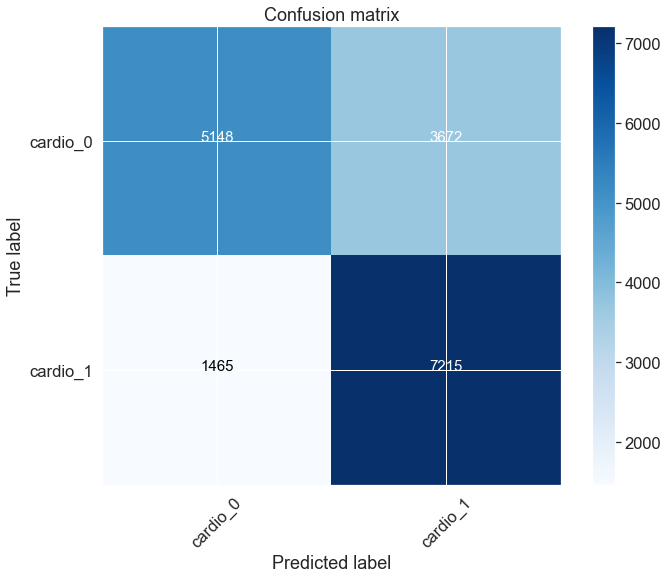

In [17]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score_boost>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [18]:
TN_b = cnf_matrix[0][0]
FN_b = cnf_matrix[1][0]
TP_b = cnf_matrix[1][1]
FP_b = cnf_matrix[0][1]

TPR_b = TP_b/(TP_b+FN_b)
FPR_b = FP_b/(FP_b+TN_b)
TNR_b = TN_b/(FP_b+TN_b)
TPR_b, FPR_b, TNR_b

(0.831221198156682, 0.4163265306122449, 0.5836734693877551)

#### Классификатор Случайные лес и  кросс-валидация

In [19]:
classifier_tree = Pipeline([
    ('features',feats),
    ('classifier Tree', RandomForestClassifier(n_estimators=200, 
                                                    max_depth=4, random_state = 42)),
])


#запустим кросс-валидацию
cv_scores_tree = cross_val_score(classifier_tree, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_tree = np.mean(cv_scores_tree)
cv_score_std_tree = np.std(cv_scores_tree)
print('CV score Tree is {}+-{}'.format(cv_score_tree, cv_score_std_tree))

#обучим пайплайн на всем тренировочном датасете
classifier_tree.fit(X_train, y_train)
y_score_tree = classifier_tree.predict_proba(X_test)[:, 1]

CV score Tree is 0.7929913750441786+-0.006753227242307714


In [20]:
b=1

precision_t, recall_t, thresholds = precision_recall_curve(y_test.values, y_score_tree)
fscore_t = (1+b**2)*(precision_t * recall_t) / (b**2*precision_t + recall_t)
# locate the index of the largest f score
ix = np.argmax(fscore_t)
print('Tree Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore_t[ix],
                                                                        precision_t[ix],
                                                                        recall_t[ix]))

precision_t, recall_t, fscore_t = precision_t[ix], recall_t[ix], fscore_t[ix]

Tree Best Threshold=0.413204, F-Score=0.737, Precision=0.685, Recall=0.798


In [21]:
tree_roc_auc_score = roc_auc_score(y_true=y_test, y_score=classifier_tree.predict_proba(X_test)[:,1])
tree_log_loss_score = log_loss(y_true=y_test, y_pred=classifier_tree.predict_proba(X_test)[:,1])

print("Tree roc auc score: {}".format(tree_roc_auc_score))
print("Tree log loss score: {}".format(tree_log_loss_score))

Tree roc auc score: 0.7936842586496965
Tree log loss score: 0.566187243575619


Confusion matrix, without normalization
[[5635 3185]
 [1753 6927]]


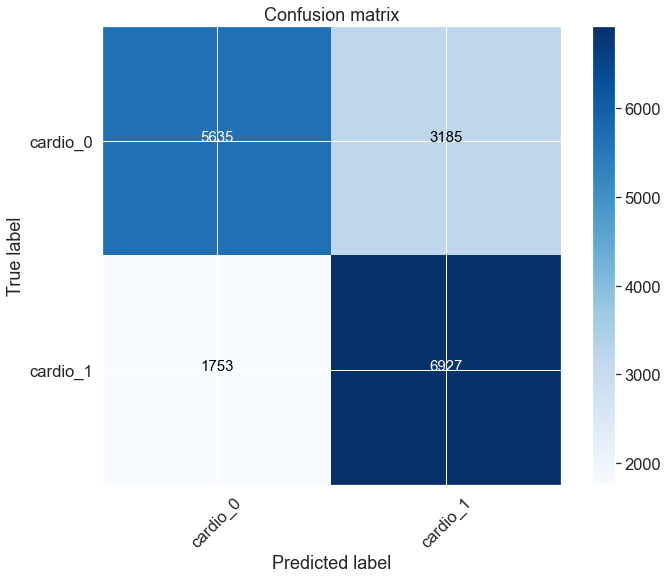

In [22]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score_tree>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [23]:
TN_tr = cnf_matrix[0][0]
FN_tr = cnf_matrix[1][0]
TP_tr = cnf_matrix[1][1]
FP_tr = cnf_matrix[0][1]

TPR_tr = TP_tr/(TP_tr+FN_tr)
FPR_tr = FP_tr/(FP_tr+TN_tr)
TNR_tr = TN_tr/(FP_tr+TN_tr)
TPR_tr, FPR_tr, TNR_tr

(0.7980414746543779, 0.3611111111111111, 0.6388888888888888)

In [24]:
d = {'Models':['Ligistic Regression', 'Tree', 'Boosting'],
     'roc auc':[lr_roc_auc_score, tree_roc_auc_score, boost_roc_auc_score],
     'precision': [precision_lr, precision_t, precision_b],
    'recall': [recall_lr, recall_t, recall_b],
     'fscore':[fscore_lr, fscore_t, fscore_b]
    }
results = pd.DataFrame(data = d)
results

,Models,roc auc,precision,recall,fscore
0,Linear Regression,0.784035,0.647431,0.837558,0.730323
1,Tree,0.793684,0.685059,0.798157,0.737296
2,Boosting,0.798917,0.662748,0.831336,0.737531


#### Выводы

Я не занималась особым подбором гиперпараметров и тп (кроме бустинга), поэтому данные вверху получены в base mode. По ним видно, что fscore чуть выше у бустинга. Но если вспомнить, что наша задача - корректно идентифицировать тех, у кого возможны проблемы с сердцем, то нам важно их не пропустить. То есть FP должен быть минимальным. Минимальный он у случайных деревьев. Но это я так решила, что он должен быть минимальным и это важнее, чем пропустить здоровых с лейблом "болен"..